Forecasting Walmart Sales with Machine Learning <br>Copyright (C) 2021 Wagner Bertholdo Burghausen <br><https://github.com/wagner-b>, <wagb2b2@gmail.com> <br> <br>This program is free software: you can redistribute it and/or modify <br>it under the terms of the GNU General Public License as published by <br>the Free Software Foundation, either version 3 of the License, or <br>(at your option) any later version. <br> <br>This program is distributed in the hope that it will be useful, <br>but WITHOUT ANY WARRANTY; without even the implied warranty of <br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the <br>GNU General Public License for more details. <br> <br>You should have received a copy of the GNU General Public License <br>along with this program.  If not, see <https://www.gnu.org/licenses/>. <br>

# Forecasting Walmart Sales

> In this project I will use data from the [Kaggle](https://www.kaggle.com) competition: [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). The goal of this project is to build an useful machine learning model that can predict sales with resonable accuracy based on historic sales data. This individual project is part of the requirements of the [Machine Learning with Python: Zero to GBMs](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms) course, a free, online certification course, hosted on [Jovian](https://jovian.ai).

## 1 - Downloading and importing the necessary modules and the dataset

In [ ]:
!pip install opendatasets jovian numpy pandas matplotlib seaborn scikit-learn pyarrow xgboost

In [1]:
import os
import opendatasets as od
import jovian
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%matplotlib inline
matplotlib.rcParams['font.size'] = 14
sns.set_style('whitegrid')

In [ ]:
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting')

In [2]:
data_folder = 'walmart-recruiting-store-sales-forecasting'
os.listdir(data_folder)

['stores.csv',
 'features.csv.zip',
 'sampleSubmission.csv.zip',
 'test.csv.zip',
 'train.csv.zip']

In [3]:
stores_df = pd.read_csv(data_folder + '/stores.csv')
train_df = pd.read_csv(data_folder + '/train.csv.zip')
submission_df = pd.read_csv(data_folder + '/sampleSubmission.csv.zip')
features_df = pd.read_csv(data_folder + '/features.csv.zip')
test_df = pd.read_csv(data_folder + '/test.csv.zip')

In [4]:
stores_df

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [5]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [6]:
submission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0
...,...,...
115059,45_98_2013-06-28,0
115060,45_98_2013-07-05,0
115061,45_98_2013-07-12,0
115062,45_98_2013-07-19,0


In [7]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [8]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


The data was imported successfully. Now, I will upload this notebook to my [Jovian](https://jovian.ai) profile. I will keep uploading this notebook from time to time to [Jovian](https://jovian.ai).

In [ ]:
jovian.commit()

## 2 - Understanding the dataset description and problem statement

The following text contains the description about this dataset and the problem statement, and was excerpted from <https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data>:

> "You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

> stores.csv - This file contains anonymized information about the 45 stores, indicating the type and size of store.

> train.csv - This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields: Store - the store number; Dept - the department number; Date - the week; Weekly_Sales -  sales for the given department in the given store; IsHoliday - whether the week is a special holiday week.

> test.csv - This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

> features.csv - This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields: Store - the store number; Date - the week; Temperature - average temperature in the region; Fuel_Price - cost of fuel in the region; MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA; CPI - the consumer price index; Unemployment - the unemployment rate; IsHoliday - whether the week is a special holiday week.

> For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data): Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13; Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13; Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13; Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13."

Excerpted from: <https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data>

So first, I need to merge the `features_df` with `stores_df`, and then merge it again with `train_df` and `test_df`, so I can have access to all training data in just one dataframe, rather than having this data spread over 3 different dataframes.

After that, I should do basic exploratory data analysis to have a better understanding about the general patterns of this data, and what variables tend to affect sales the most. Then I will start training machine learining models to predict sales.

In [ ]:
jovian.commit()

## 3 - Data preparation and exploratory data analysis

### 3.1 - Basic data preparation

Let's merge the `features_df` and `stores_df` dataframes

In [9]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [10]:
stores_df

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [11]:
full_features_df = features_df.merge(stores_df, how='inner', on='Store')

In [12]:
full_features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221


In [13]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [14]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [15]:
train_val_df = train_df.merge(full_features_df, how='inner', on=['Store', 'Date', 'IsHoliday'])

In [16]:
test_df = test_df.merge(full_features_df, how='inner', on=['Store', 'Date', 'IsHoliday'])

In [17]:
train_val_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221


In [18]:
test_df

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221
115060,45,94,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221
115061,45,95,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221
115062,45,97,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221


Great! The dataframes were successfully merged, and now I have all the data for the train/validation set in just one dataframe

In [19]:
del full_features_df, train_df, features_df, stores_df

In [20]:
train_val_df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
dtype: object

In [21]:
test_df.dtypes

Store             int64
Dept              int64
Date             object
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
dtype: object

The `Date` column is marked as an `object` dtype, so I need to convert to a `datetime` dtype. It is important to note that the day in the `Date` column is always a friday. From my understanding of the dataset description, it is clear that the `Date` column represents only the week, and not the exact day. This dataset contains rows of weekly sales, not daily sales. This is why it is important to extract the week, the month and the year from the `Date` column.

In [22]:
train_val_df.Date = pd.to_datetime(train_val_df.Date)
test_df.Date = pd.to_datetime(test_df.Date)

In [23]:
train_val_df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

In [24]:
test_df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

In [25]:
train_val_df['Week'] = train_val_df.Date.dt.week
train_val_df['Month'] = train_val_df.Date.dt.month
train_val_df['Year'] = train_val_df.Date.dt.year

<ipython-input-25-4af02918cfca>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_val_df['Week'] = train_val_df.Date.dt.week


In [26]:
train_val_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,43,10,2012
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,43,10,2012
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,43,10,2012
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,43,10,2012


In [27]:
test_df['Week'] = test_df.Date.dt.week
test_df['Month'] = test_df.Date.dt.month
test_df['Year'] = test_df.Date.dt.year
test_df

<ipython-input-27-d6808fa92ec6>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['Week'] = test_df.Date.dt.week


,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,11,2012
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,11,2012
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,11,2012
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,11,2012
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,11,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,30,7,2013
115060,45,94,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,30,7,2013
115061,45,95,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,30,7,2013
115062,45,97,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,30,7,2013


In [ ]:
jovian.commit()

### 3.2 - Exploratory data analysis

In [28]:
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [29]:
train_val_df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Week,Month,Year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739,25.826762,6.449510,2010.968591
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328,14.151887,3.243217,0.796876
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000,14.000000,4.000000,2010.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000,26.000000,6.000000,2011.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000,38.000000,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,52.000000,12.000000,2012.000000


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Temperature   115064 non-null  float64       
 5   Fuel_Price    115064 non-null  float64       
 6   MarkDown1     114915 non-null  float64       
 7   MarkDown2     86437 non-null   float64       
 8   MarkDown3     105235 non-null  float64       
 9   MarkDown4     102176 non-null  float64       
 10  MarkDown5     115064 non-null  float64       
 11  CPI           76902 non-null   float64       
 12  Unemployment  76902 non-null   float64       
 13  Type          115064 non-null  object        
 14  Size          115064 non-null  int64         
 15  Week          115

In [31]:
test_df.describe()

,Store,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Week,Month,Year
count,115064.000000,115064.000000,115064.000000,115064.000000,114915.000000,86437.000000,105235.000000,102176.000000,115064.000000,76902.000000,76902.000000,115064.000000,115064.000000,115064.000000,115064.000000
mean,22.238207,44.339524,53.941804,3.581546,7689.216439,3734.051729,2403.088666,3356.219071,3922.681189,176.961347,6.868733,136497.688921,23.050963,5.729855,2012.767182
std,12.809930,30.656410,18.724153,0.239442,10698.760716,8323.495014,13767.939313,7570.501545,19445.150745,41.239967,1.583427,61106.926438,15.750407,3.590331,0.422629
min,1.000000,1.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.220000,-185.170000,131.236226,3.684000,34875.000000,1.000000,1.000000,2012.000000
25%,11.000000,18.000000,39.820000,3.431000,1966.460000,180.350000,15.100000,155.460000,1309.300000,138.402033,5.771000,93638.000000,10.000000,3.000000,2013.000000
50%,22.000000,37.000000,54.470000,3.606000,4842.290000,742.590000,78.260000,840.940000,2390.430000,192.304445,6.806000,140167.000000,20.000000,5.000000,2013.000000
75%,33.000000,74.000000,67.350000,3.766000,9439.140000,2735.670000,272.580000,3096.920000,4227.270000,223.244532,8.036000,202505.000000,30.000000,7.000000,2013.000000
max,45.000000,99.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000,219622.000000,52.000000,12.000000,2013.000000


In [32]:
train_val_df.Year.value_counts()

2011    153453
2010    140679
2012    127438
Name: Year, dtype: int64

In [33]:
test_df.Year.value_counts()

2013    88275
2012    26789
Name: Year, dtype: int64

In [ ]:
jovian.commit()

In [34]:
train_val_df.Type.value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [35]:
test_df.Type.value_counts()

A    58713
B    44500
C    11851
Name: Type, dtype: int64

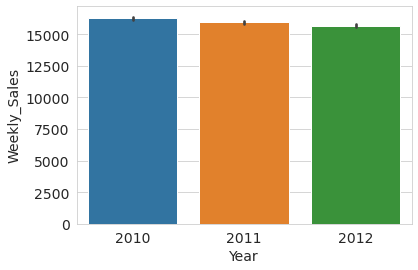

In [36]:
sns.barplot(x='Year', y='Weekly_Sales', data=train_val_df);

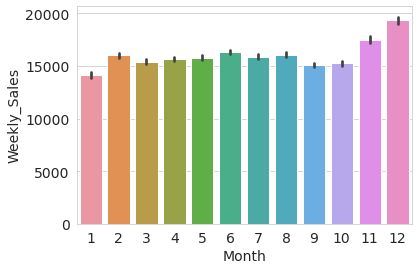

In [37]:
sns.barplot(x='Month', y='Weekly_Sales', data=train_val_df);

> There seems to be more sales in November and December, compared to the other months.

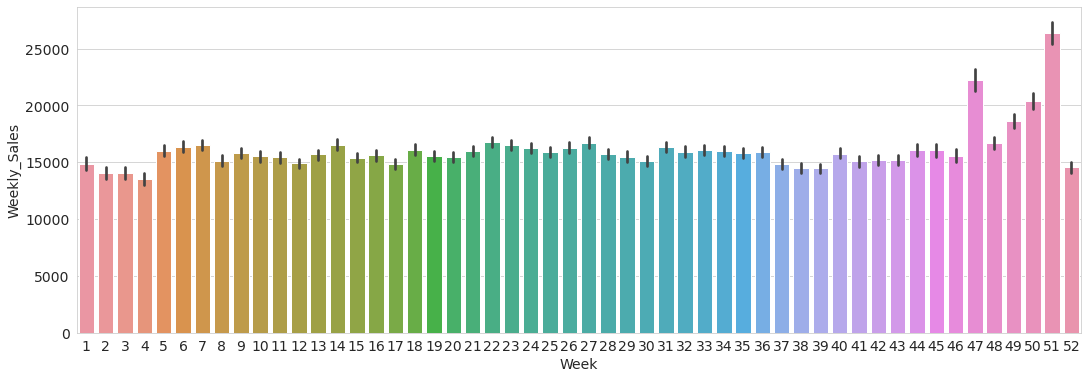

In [38]:
plt.figure(figsize=(18, 6))
sns.barplot(x='Week', y='Weekly_Sales', data=train_val_df);

> Once again, this plot shows higher sales near the end of the year.

**Weekly Sales x Size of the Store**

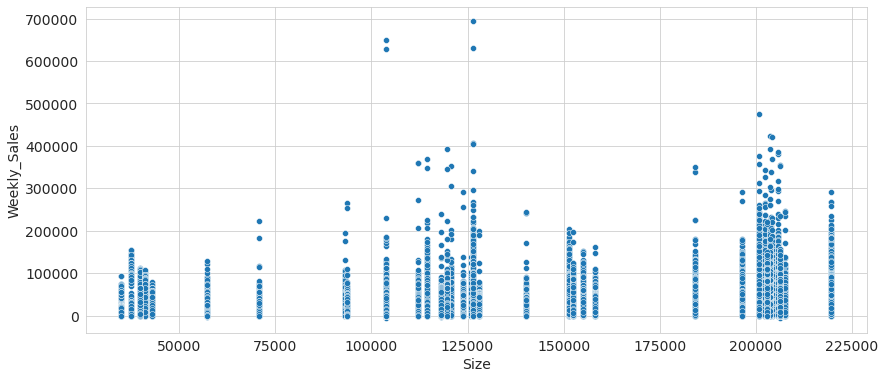

In [39]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='Size', y='Weekly_Sales', data=train_val_df);

> Excluding some outliers, it seems that larger stores tend to have higher weekly sales

**Weekly sales x Store type**

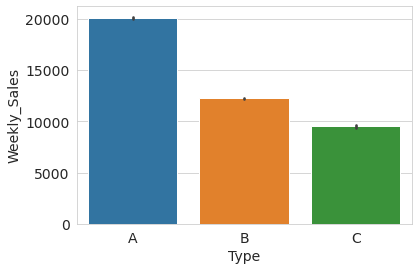

In [40]:
sns.barplot(x='Type', y='Weekly_Sales', data=train_val_df);

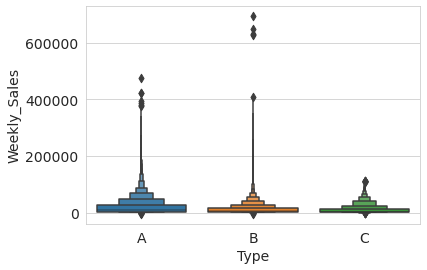

In [41]:
sns.boxenplot(x='Type', y='Weekly_Sales', data=train_val_df);

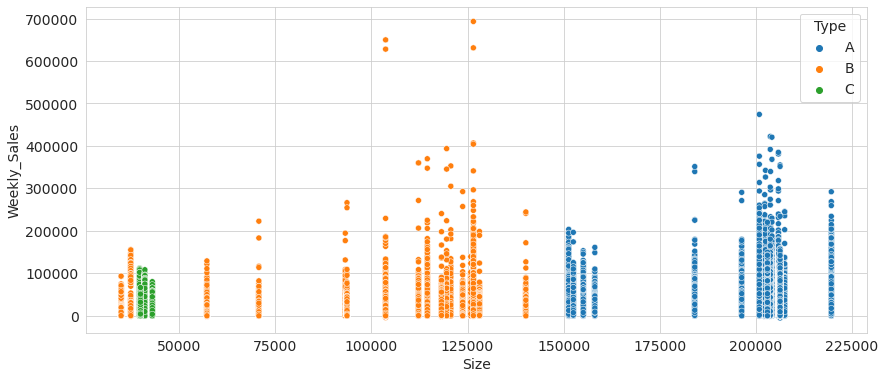

In [42]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='Size', y='Weekly_Sales', hue='Type', data=train_val_df);

> It seems there is some kind of relationship between the size of a store and the "type" of a store. "Type A" stores seem to be large-sized stores, "type B" stores seem to be small-to-medium-sized stores, and "type C" stores seem to be small-sized stores. Excluding some outliers, it seems that larger stores tend to have higher weekly sales, and that could possibly be the main reason why "type A" stores seem to have higher weekly sales than "type B" stores, which seem to have higher weekly sales than "type C" stores.

In [ ]:
jovian.commit()

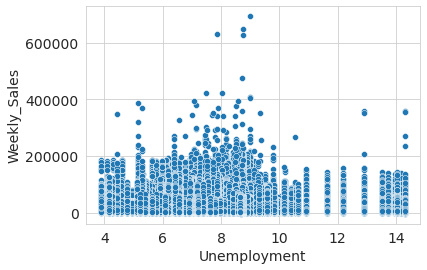

In [43]:
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=train_val_df);

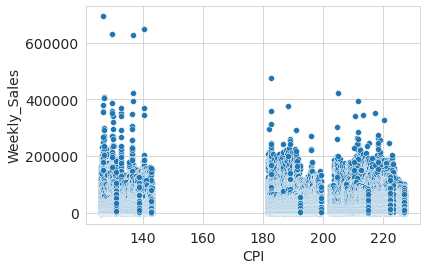

In [44]:
sns.scatterplot(x='CPI', y='Weekly_Sales', data=train_val_df);

The text below was exerpted from <https://www.investopedia.com/terms/c/consumerpriceindex.asp>:
>  "What Is Consumer Price Index (CPI)?"

> "The Consumer Price Index (CPI) is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care. It is calculated by taking price changes for each item in the predetermined basket of goods and averaging them. Changes in the CPI are used to assess price changes associated with the cost of living."

Source: <https://www.investopedia.com/terms/c/consumerpriceindex.asp>

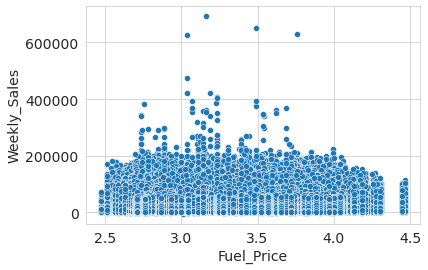

In [45]:
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=train_val_df);

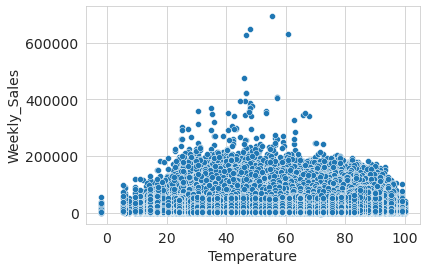

In [46]:
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=train_val_df);

> It seems when it's either too cold or too hot, there are lower sales.

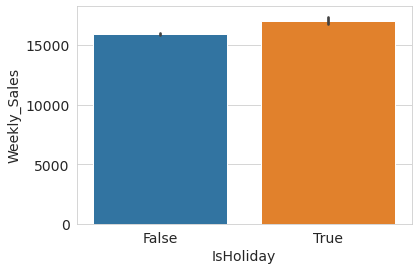

In [47]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=train_val_df);

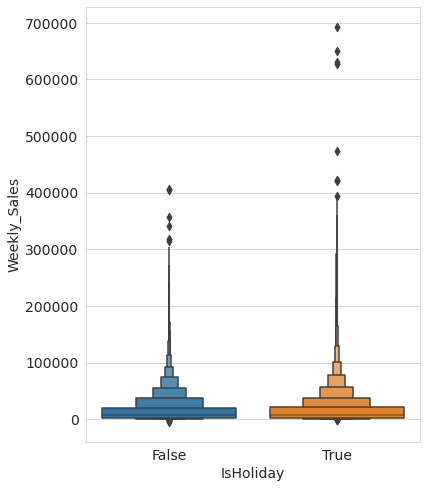

In [48]:
plt.figure(figsize=(6,8))
sns.boxenplot(x='IsHoliday', y='Weekly_Sales', data=train_val_df);

> It seems there is a tendency of higher sales in the holidays

In [ ]:
jovian.commit()

**Correlation between variables**

The lines of code below were inspired by [Caio Avelino's Notebook on the Walmart Store Sale Forecasting (Kaggle competition)](https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting).

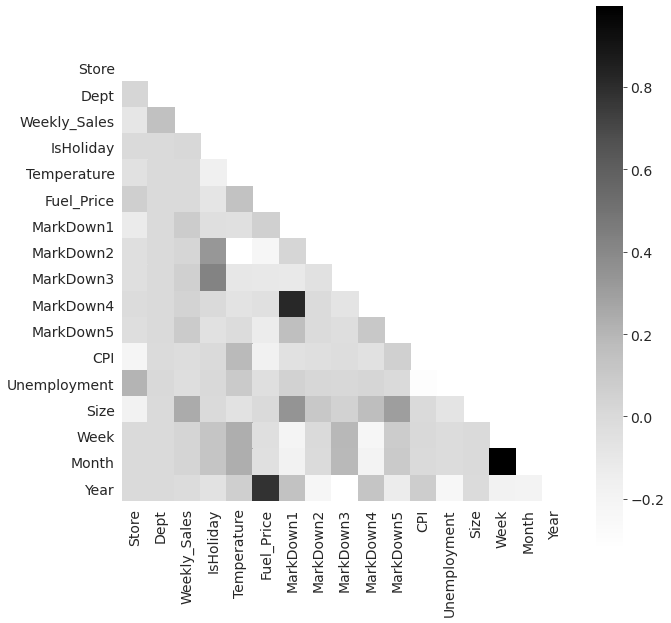

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_val_df.corr(), square=True, cmap='Greys',
            mask = np.triu(np.ones_like(train_val_df.corr(), dtype='bool')));

> The only variables with high correlation seem to be Week and Month, MarkDown1 and MarkDown4, and Fuel_Price and Year.

In [ ]:
jovian.commit()

### 3.3 - Creating the training-validation split and preparing the data for modelling

In [50]:
train_val_df.Year.value_counts()

2011    153453
2010    140679
2012    127438
Name: Year, dtype: int64

I will use the data of 2010 and 2011 for the training dataset, and the data from 2012 for the validation dataset

In [51]:
train_df = train_val_df[train_val_df.Year < 2012]
val_df = train_val_df[train_val_df.Year == 2012]

Selecting input and target columns

In [52]:
input_cols = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI',
              'Unemployment', 'Type', 'Size', 'Week']
target_col = 'Weekly_Sales'

In [53]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [54]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [55]:
test_inputs = test_df[input_cols].copy()

In [56]:
train_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week
0,1,1,False,42.31,2.572,211.096358,8.106,A,151315,5
1,1,2,False,42.31,2.572,211.096358,8.106,A,151315,5
2,1,3,False,42.31,2.572,211.096358,8.106,A,151315,5
3,1,4,False,42.31,2.572,211.096358,8.106,A,151315,5
4,1,5,False,42.31,2.572,211.096358,8.106,A,151315,5
...,...,...,...,...,...,...,...,...,...,...
418660,45,93,True,37.79,3.389,189.062016,8.523,B,118221,52
418661,45,94,True,37.79,3.389,189.062016,8.523,B,118221,52
418662,45,95,True,37.79,3.389,189.062016,8.523,B,118221,52
418663,45,97,True,37.79,3.389,189.062016,8.523,B,118221,52


In [57]:
train_targets

0         24924.50
1         50605.27
2         13740.12
3         39954.04
4         32229.38
            ...   
418660     1426.52
418661     2979.03
418662    42084.36
418663     5569.82
418664      553.21
Name: Weekly_Sales, Length: 294132, dtype: float64

In [58]:
val_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week
7169,1,1,False,49.01,3.157,219.714258,7.348,A,151315,1
7170,1,2,False,49.01,3.157,219.714258,7.348,A,151315,1
7171,1,3,False,49.01,3.157,219.714258,7.348,A,151315,1
7172,1,4,False,49.01,3.157,219.714258,7.348,A,151315,1
7173,1,5,False,49.01,3.157,219.714258,7.348,A,151315,1
...,...,...,...,...,...,...,...,...,...,...
421565,45,93,False,58.85,3.882,192.308899,8.667,B,118221,43
421566,45,94,False,58.85,3.882,192.308899,8.667,B,118221,43
421567,45,95,False,58.85,3.882,192.308899,8.667,B,118221,43
421568,45,97,False,58.85,3.882,192.308899,8.667,B,118221,43


In [59]:
val_targets

7169      16567.69
7170      44481.38
7171      13926.04
7172      40925.76
7173      23105.81
            ...   
421565     2487.80
421566     5203.31
421567    56017.47
421568     6817.48
421569     1076.80
Name: Weekly_Sales, Length: 127438, dtype: float64

In [60]:
test_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week
0,1,1,False,55.32,3.386,223.462779,6.573,A,151315,44
1,1,2,False,55.32,3.386,223.462779,6.573,A,151315,44
2,1,3,False,55.32,3.386,223.462779,6.573,A,151315,44
3,1,4,False,55.32,3.386,223.462779,6.573,A,151315,44
4,1,5,False,55.32,3.386,223.462779,6.573,A,151315,44
...,...,...,...,...,...,...,...,...,...,...
115059,45,93,False,76.06,3.804,NaN,NaN,B,118221,30
115060,45,94,False,76.06,3.804,NaN,NaN,B,118221,30
115061,45,95,False,76.06,3.804,NaN,NaN,B,118221,30
115062,45,97,False,76.06,3.804,NaN,NaN,B,118221,30


In [61]:
numeric_cols = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'Week']

In [62]:
categorical_cols = ['Type']

### Imputing missing numeric values in the `test_inputs` dataframe

In [63]:
test_inputs.isna().sum()

Store               0
Dept                0
IsHoliday           0
Temperature         0
Fuel_Price          0
CPI             38162
Unemployment    38162
Type                0
Size                0
Week                0
dtype: int64

In [64]:
imputer = SimpleImputer(strategy='mean').fit(test_inputs[numeric_cols])

In [65]:
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [66]:
test_inputs.isna().sum()

Store           0
Dept            0
IsHoliday       0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Type            0
Size            0
Week            0
dtype: int64

In [67]:
train_inputs.isna().sum()

Store           0
Dept            0
IsHoliday       0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Type            0
Size            0
Week            0
dtype: int64

In [68]:
val_inputs.isna().sum()

Store           0
Dept            0
IsHoliday       0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Type            0
Size            0
Week            0
dtype: int64

Good! Now, there is no missing values anymore!

### Scaling numeric features

In [69]:
full_inputs_df = pd.concat([train_inputs, val_inputs, test_inputs])

In [70]:
scaler = MinMaxScaler().fit(full_inputs_df[numeric_cols])

In [71]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [72]:
train_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week
0,0.0,0.000000,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431
1,0.0,0.010204,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431
2,0.0,0.020408,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431
3,0.0,0.030612,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431
4,0.0,0.040816,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431
...,...,...,...,...,...,...,...,...,...,...
418660,1.0,0.938776,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000
418661,1.0,0.948980,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000
418662,1.0,0.959184,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000
418663,1.0,0.979592,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000


In [73]:
val_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week
7169,0.0,0.000000,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000
7170,0.0,0.010204,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000
7171,0.0,0.020408,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000
7172,0.0,0.030612,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000
7173,0.0,0.040816,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000
...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529
421566,1.0,0.948980,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529
421567,1.0,0.959184,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529
421568,1.0,0.979592,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529


In [74]:
test_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week
0,0.0,0.000000,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137
1,0.0,0.010204,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137
2,0.0,0.020408,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137
3,0.0,0.030612,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137
4,0.0,0.040816,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137
...,...,...,...,...,...,...,...,...,...,...
115059,1.0,0.938776,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627
115060,1.0,0.948980,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627
115061,1.0,0.959184,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627
115062,1.0,0.979592,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627


In [75]:
train_inputs.describe().loc[['min', 'max']]

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week
min,0.0,0.0,0.0,0.047876,0.000000,0.000000,0.069245,0.0,0.0
max,1.0,1.0,1.0,0.983431,0.871242,0.944353,1.000000,1.0,1.0


In [76]:
val_inputs.describe().loc[['min', 'max']]

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week
min,0.0,0.0,0.0,0.135024,0.28006,0.039777,0.018346,0.0,0.000000
max,1.0,1.0,1.0,0.982790,1.00000,0.983057,0.799981,1.0,0.823529


In [77]:
test_inputs.describe().loc[['min', 'max']]

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week
min,0.0,0.0,0.0,0.0,0.200401,0.050259,0.000000,0.0,0.0
max,1.0,1.0,1.0,1.0,0.828156,1.000000,0.612946,1.0,1.0


In [ ]:
jovian.commit()

### Encoding categorical data

In [78]:
encoder = OneHotEncoder(sparse=False).fit(full_inputs_df[categorical_cols])

In [79]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [80]:
encoded_cols

['Type_A', 'Type_B', 'Type_C']

In [81]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [82]:
train_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Type_A,Type_B,Type_C
0,0.0,0.000000,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431,1.0,0.0,0.0
1,0.0,0.010204,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431,1.0,0.0,0.0
2,0.0,0.020408,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431,1.0,0.0,0.0
3,0.0,0.030612,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431,1.0,0.0,0.0
4,0.0,0.040816,0.0,0.454046,0.050100,0.826259,0.416032,A,0.630267,0.078431,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
418660,1.0,0.938776,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000,0.0,1.0,0.0
418661,1.0,0.948980,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000,0.0,1.0,0.0
418662,1.0,0.959184,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000,0.0,1.0,0.0
418663,1.0,0.979592,1.0,0.412669,0.459419,0.612152,0.455264,B,0.451136,1.000000,0.0,1.0,0.0


In [83]:
val_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Type_A,Type_B,Type_C
7169,0.0,0.000000,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000,1.0,0.0,0.0
7170,0.0,0.010204,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000,1.0,0.0,0.0
7171,0.0,0.020408,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000,1.0,0.0,0.0
7172,0.0,0.030612,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000,1.0,0.0,0.0
7173,0.0,0.040816,0.0,0.515379,0.343186,0.909999,0.344717,A,0.630267,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529,0.0,1.0,0.0
421566,1.0,0.948980,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529,0.0,1.0,0.0
421567,1.0,0.959184,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529,0.0,1.0,0.0
421568,1.0,0.979592,0.0,0.605456,0.706413,0.643701,0.468812,B,0.451136,0.823529,0.0,1.0,0.0


In [84]:
test_inputs

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Type_A,Type_B,Type_C
0,0.0,0.000000,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137,1.0,0.0,0.0
1,0.0,0.010204,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137,1.0,0.0,0.0
2,0.0,0.020408,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137,1.0,0.0,0.0
3,0.0,0.030612,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137,1.0,0.0,0.0
4,0.0,0.040816,0.0,0.573142,0.457916,0.946424,0.271804,A,0.630267,0.843137,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,1.0,0.938776,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627,0.0,1.0,0.0
115060,1.0,0.948980,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627,0.0,1.0,0.0
115061,1.0,0.959184,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627,0.0,1.0,0.0
115062,1.0,0.979592,0.0,0.762999,0.667335,0.494569,0.299627,B,0.451136,0.568627,0.0,1.0,0.0


**Done! To finish data preparation for modelling, I will drop the categorical column (Type) from the dataframes I'll use for training ML models, because I already have the encoded columns.**

In [85]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [86]:
X_train

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week,Type_A,Type_B,Type_C
0,0.0,0.000000,0.0,0.454046,0.050100,0.826259,0.416032,0.630267,0.078431,1.0,0.0,0.0
1,0.0,0.010204,0.0,0.454046,0.050100,0.826259,0.416032,0.630267,0.078431,1.0,0.0,0.0
2,0.0,0.020408,0.0,0.454046,0.050100,0.826259,0.416032,0.630267,0.078431,1.0,0.0,0.0
3,0.0,0.030612,0.0,0.454046,0.050100,0.826259,0.416032,0.630267,0.078431,1.0,0.0,0.0
4,0.0,0.040816,0.0,0.454046,0.050100,0.826259,0.416032,0.630267,0.078431,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
418660,1.0,0.938776,1.0,0.412669,0.459419,0.612152,0.455264,0.451136,1.000000,0.0,1.0,0.0
418661,1.0,0.948980,1.0,0.412669,0.459419,0.612152,0.455264,0.451136,1.000000,0.0,1.0,0.0
418662,1.0,0.959184,1.0,0.412669,0.459419,0.612152,0.455264,0.451136,1.000000,0.0,1.0,0.0
418663,1.0,0.979592,1.0,0.412669,0.459419,0.612152,0.455264,0.451136,1.000000,0.0,1.0,0.0


In [87]:
X_val

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week,Type_A,Type_B,Type_C
7169,0.0,0.000000,0.0,0.515379,0.343186,0.909999,0.344717,0.630267,0.000000,1.0,0.0,0.0
7170,0.0,0.010204,0.0,0.515379,0.343186,0.909999,0.344717,0.630267,0.000000,1.0,0.0,0.0
7171,0.0,0.020408,0.0,0.515379,0.343186,0.909999,0.344717,0.630267,0.000000,1.0,0.0,0.0
7172,0.0,0.030612,0.0,0.515379,0.343186,0.909999,0.344717,0.630267,0.000000,1.0,0.0,0.0
7173,0.0,0.040816,0.0,0.515379,0.343186,0.909999,0.344717,0.630267,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,0.0,0.605456,0.706413,0.643701,0.468812,0.451136,0.823529,0.0,1.0,0.0
421566,1.0,0.948980,0.0,0.605456,0.706413,0.643701,0.468812,0.451136,0.823529,0.0,1.0,0.0
421567,1.0,0.959184,0.0,0.605456,0.706413,0.643701,0.468812,0.451136,0.823529,0.0,1.0,0.0
421568,1.0,0.979592,0.0,0.605456,0.706413,0.643701,0.468812,0.451136,0.823529,0.0,1.0,0.0


In [88]:
X_test

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week,Type_A,Type_B,Type_C
0,0.0,0.000000,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0
1,0.0,0.010204,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0
2,0.0,0.020408,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0
3,0.0,0.030612,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0
4,0.0,0.040816,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115059,1.0,0.938776,0.0,0.762999,0.667335,0.494569,0.299627,0.451136,0.568627,0.0,1.0,0.0
115060,1.0,0.948980,0.0,0.762999,0.667335,0.494569,0.299627,0.451136,0.568627,0.0,1.0,0.0
115061,1.0,0.959184,0.0,0.762999,0.667335,0.494569,0.299627,0.451136,0.568627,0.0,1.0,0.0
115062,1.0,0.979592,0.0,0.762999,0.667335,0.494569,0.299627,0.451136,0.568627,0.0,1.0,0.0


**Done! Now I have the data ready to start training machine learning models!**

In [ ]:
jovian.commit()

But first, I will save the processed data to disk, using the parket format

In [ ]:
os.mkdir('processed_data')

In [ ]:
folder = 'processed_data/'
X_train.to_parquet(folder + 'X_train.parquet')
pd.DataFrame(train_targets).to_parquet(folder + 'train_targets.parquet')

X_val.to_parquet(folder + 'X_val.parquet')
pd.DataFrame(val_targets).to_parquet(folder + 'val_targets.parquet')

X_test.to_parquet(folder + 'X_test.parquet')

Done! The data can be read using `pd.read_parket`

In [2]:
folder = 'processed_data/'

X_train = pd.read_parquet(folder + 'X_train.parquet')
train_targets = pd.read_parquet(folder + 'train_targets.parquet')['Weekly_Sales']

X_val = pd.read_parquet(folder + 'X_val.parquet')
val_targets = pd.read_parquet(folder + 'val_targets.parquet')['Weekly_Sales']

X_test = pd.read_parquet(folder + 'X_test.parquet')

In [3]:
print(X_train.shape)
print(train_targets.shape)

print(X_val.shape)
print(val_targets.shape)

print(X_test.shape)

(294132, 12)
(294132,)
(127438, 12)
(127438,)
(115064, 12)


In [ ]:
jovian.commit()

# 4 - Train, evaluate and improve 2 different types of machine learning models

## 4.1 - Random Forest Regressor model

First, I will train a random forest regressor model without tuning any hyperparameters. Then, based on the error scores of this model on the training and validation datasets, I will tune at least 2 hyperparameters of the model to minimize the error of the validation dataset for predicting weekly sales.

In [91]:
rand_forest1 = RandomForestRegressor(random_state=42, n_jobs=-1)

In [92]:
rand_forest1.fit(X_train, train_targets)

RandomForestRegressor(n_jobs=-1, random_state=42)

The model was fitted to the training dataset. Now I will calculate the training error and the validation error of this model, based on the difference between the values predicted by the model _versus_ the real values of weekly sales.

However, as it was stated in section 2 ("Understanding the dataset description and problem statement"), for the evaluation of the model, the weeks including holidays should be weighted five times higher than non-holiday weeks

> "The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks."

(Excerpted from: <https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data>)

Therefore, I will use the Weighted Mean Absolute Error (WMAE), with a weight of 5 for holiday weeks, and a weight of 1 for non-holiday weeks, as the error estimate to evaluate my models here. I shall give the credits to Caio Avelino for helping me with these 2 cells of code below (i.e. the two cells of code below were inspired by [Caio Avelino's Notebook on the Walmart Store Sale Forecasting](https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting)).

In [93]:
weights_train = X_train.IsHoliday.apply(lambda x: 5 if x else 1)
weights_val = X_val.IsHoliday.apply(lambda x: 5 if x else 1)

In [94]:
train_wmae = np.sum(np.multiply(abs(train_targets - rand_forest1.predict(X_train)), weights_train)) / (np.sum(weights_train))
val_wmae = np.sum(np.multiply(abs(val_targets - rand_forest1.predict(X_val)), weights_val)) / (np.sum(weights_val))
train_wmae, val_wmae

(621.9462100285929, 2301.9549316272983)

Now that I know the error for the training and validation datasets for the "basic" random forest regressor (i.e. the first model built with the default settings, without tuning any hyperparameters), I can start tuning the hyperparameters to reduce as much as possible the error of the model for the validation dataset.

**Tuning the hyperparameters for random forest regression model**

These helper functions below will help me tune the hyperparameters:

In [4]:
def test_param(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    weights_train = X_train.IsHoliday.apply(lambda x: 5 if x else 1)
    weights_val = X_val.IsHoliday.apply(lambda x: 5 if x else 1)
    train_wmae = np.sum(np.multiply(abs(train_targets - model.predict(X_train)), weights_train)) / (np.sum(weights_train))
    val_wmae = np.sum(np.multiply(abs(val_targets - model.predict(X_val)), weights_val)) / (np.sum(weights_val))
    return train_wmae, val_wmae

In [5]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    
    # Computing and appending the errors
    for value in param_values:
        param = {param_name: value}
        train_wmae, val_wmae = test_param(**param)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
        
    # Printing the errors for each parameter value
    print("Param_values:", param_values)
    print("Training_errors:", train_errors)
    print('Validation_errors:', val_errors)
    
    # Plotting the overfitting curve for the parameter
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Weighted Mean Absolute Error (WMAE)')
    plt.legend(['Training', 'Validation'])

Param_values: [60, 100, 140, 180, 220]
Training_errors: [628.0526130121605, 621.946210028593, 618.9091480688052, 616.8075525315613, 616.1679198617431]
Validation_errors: [2301.880092900039, 2301.9549316272983, 2297.5724596517744, 2294.2803784721764, 2293.9388175136955]


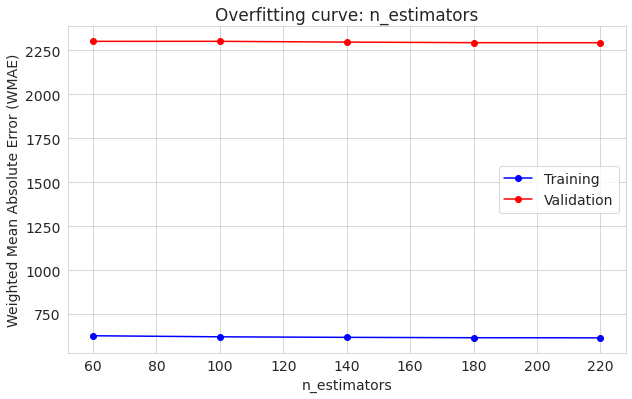

In [97]:
test_param_and_plot('n_estimators', [60, 100, 140, 180, 220])

Param_values: [20, 30, 40, 50]
Training_errors: [879.6532054825476, 625.2893262879733, 622.733393714774, 621.9053147942444]
Validation_errors: [2316.274608171306, 2298.289256220071, 2298.8191528952684, 2301.765988849087]


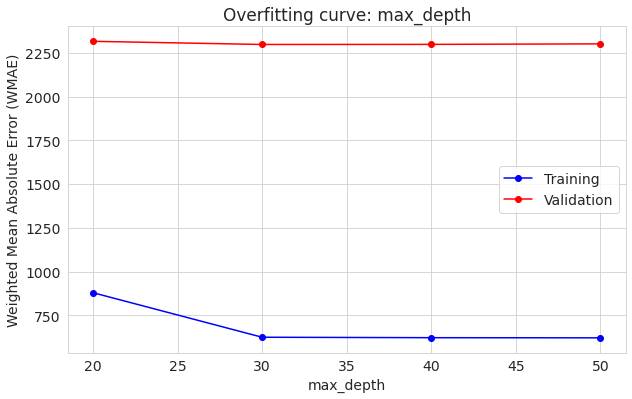

In [98]:
test_param_and_plot('max_depth', [20, 30, 40, 50])

The ideal value in order to minimize the validation error for the hyperparameter `max_depth` seems to be `30`.

Param_values: [6, 8, 9, 10, 11, 12]
Training_errors: [851.6931688162754, 649.7842760562909, 625.8325730956936, 618.6801021184958, 617.8593950759564, 621.9462100285929]
Validation_errors: [2503.927646456849, 2228.9701894855452, 2193.7630072647485, 2185.5397857917073, 2231.437034639737, 2301.9549316272983]


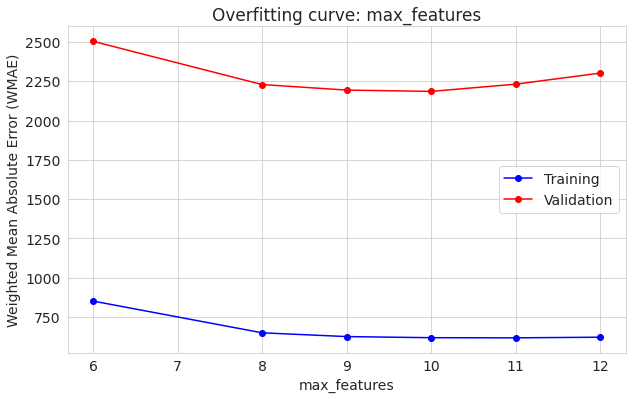

In [99]:
test_param_and_plot('max_features', [6, 8, 9, 10, 11, 12])

The ideal value in order to minimize the validation error for the hyperparameter `max_features` seems to be `10`.

In [ ]:
jovian.commit()

> Now I will train the optimized model, with the 3 hyperparameters tuned to minimize validation error.

In [6]:
random_forest_regressor_model = RandomForestRegressor(n_estimators=220, max_depth=30, max_features=10,
                                                      n_jobs=-1, random_state=42).fit(X_train, train_targets)

In [7]:
test_param(n_estimators=220, max_depth=30, max_features=10)

(611.8180310285607, 2183.8875686033507)

> I have managed to bring the validation error from 2301.95 down to 2183.89, with hyperparameter tuning.

In [8]:
random_forest_regressor_model.score(X_train, train_targets)

0.9965246475632441

In [9]:
random_forest_regressor_model.score(X_val, val_targets)

0.9573520906126853

In [ ]:
jovian.commit()

Analyzing the feature importances for the final random forest model (this will indicate what are the most important variables to predict weekly sales):

In [10]:
importances_rf_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': random_forest_regressor_model.feature_importances_
}).sort_values('importance', ascending=False)

In [11]:
importances_rf_df

,feature,importance
1,Dept,0.643068
7,Size,0.155163
8,Week,0.055655
0,Store,0.049203
5,CPI,0.031911
6,Unemployment,0.015608
3,Temperature,0.013462
9,Type_A,0.011633
10,Type_B,0.010764
4,Fuel_Price,0.007151


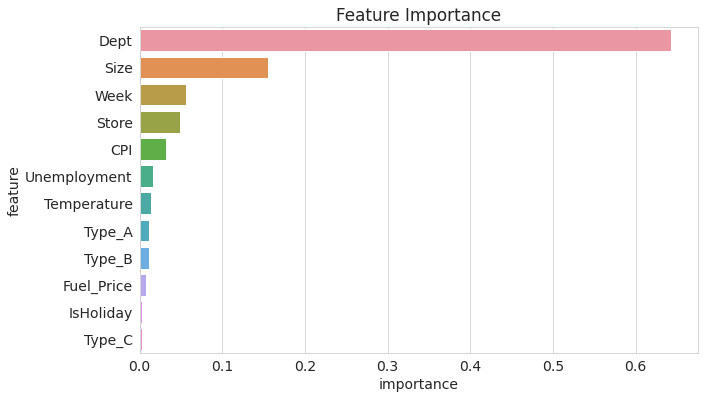

In [12]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importances_rf_df, x='importance', y='feature');

The department in the store is by far the most important factor in predicting weekly sales. The second most important factor is the physical size of the store, followed by the week, by the store itself and by the CPI (Consumer Price Index).

In [13]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "wagb2b2/course-project-forecasting-walmart-sales" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales


'https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales'

## 4.2 - Gradient Boosting Regressor model

In [14]:
xgb1 = XGBRegressor(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [15]:
weights_train = X_train.IsHoliday.apply(lambda x: 5 if x else 1)
weights_val = X_val.IsHoliday.apply(lambda x: 5 if x else 1)

In [16]:
train_wmae = np.sum(np.multiply(abs(train_targets - xgb1.predict(X_train)), weights_train)) / (np.sum(weights_train))
val_wmae = np.sum(np.multiply(abs(val_targets - xgb1.predict(X_val)), weights_val)) / (np.sum(weights_val))
train_wmae, val_wmae

(3083.543254496171, 3353.4112355369243)

In [17]:
def test_param_xgb(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    weights_train = X_train.IsHoliday.apply(lambda x: 5 if x else 1)
    weights_val = X_val.IsHoliday.apply(lambda x: 5 if x else 1)
    train_wmae = np.sum(np.multiply(abs(train_targets - model.predict(X_train)), weights_train)) / (np.sum(weights_train))
    val_wmae = np.sum(np.multiply(abs(val_targets - model.predict(X_val)), weights_val)) / (np.sum(weights_val))
    return train_wmae, val_wmae

In [18]:
def test_param_and_plot_xgb(param_name, param_values):
    train_errors, val_errors = [], []
    
    # Computing and appending the errors
    for value in param_values:
        param = {param_name: value}
        train_wmae, val_wmae = test_param_xgb(**param)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
        
    # Printing the errors for each parameter value
    print("Param_values:", param_values)
    print("Training_errors:", train_errors)
    print('Validation_errors:', val_errors)
    
    # Plotting the overfitting curve for the parameter
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Weighted Mean Absolute Error (WMAE)')
    plt.legend(['Training', 'Validation'])

Param_values: [300, 400, 500, 600, 700]
Training_errors: [2226.4551747392984, 2043.0507324247947, 1887.5989806674252, 1771.353566159152, 1686.9255329680725]
Validation_errors: [3044.7115575406233, 2979.51171677963, 2940.155792757884, 2922.699284495213, 2911.3591283840333]


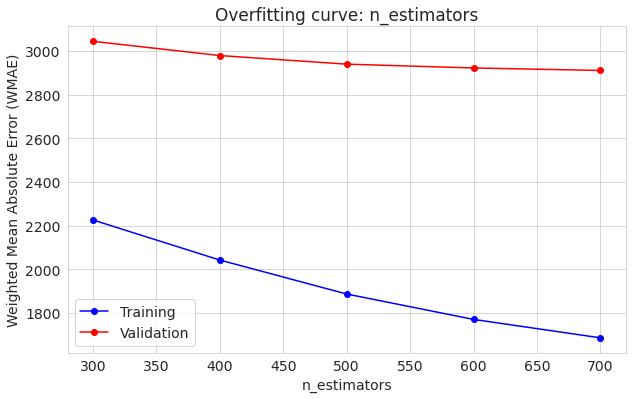

In [19]:
test_param_and_plot_xgb('n_estimators', [300, 400, 500, 600, 700])

Param_values: [10, 11, 12, 13, 14]
Training_errors: [1288.2111617303087, 992.4105480239713, 805.1707291034206, 573.5639109602918, 422.5026868696838]
Validation_errors: [2602.2082932829326, 2520.773567442808, 2486.9070070550993, 2412.400260395495, 2442.285247618881]


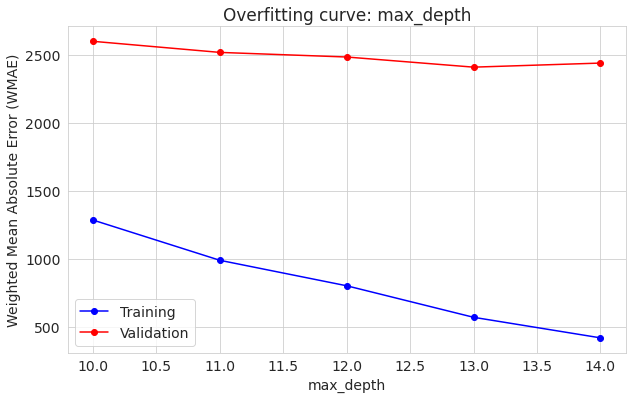

In [20]:
test_param_and_plot_xgb('max_depth', [10, 11, 12, 13, 14])

Param_values: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
Training_errors: [4050.5313248069074, 3357.062395030141, 3083.543254496171, 3010.348270739995, 2854.129115611209, 2763.3037698476683, 2770.4613585393427]
Validation_errors: [3989.195382653046, 3534.008978111458, 3353.4112355369243, 3588.2339969684585, 3357.3872414199077, 3688.628592297031, 3762.8289013518124]


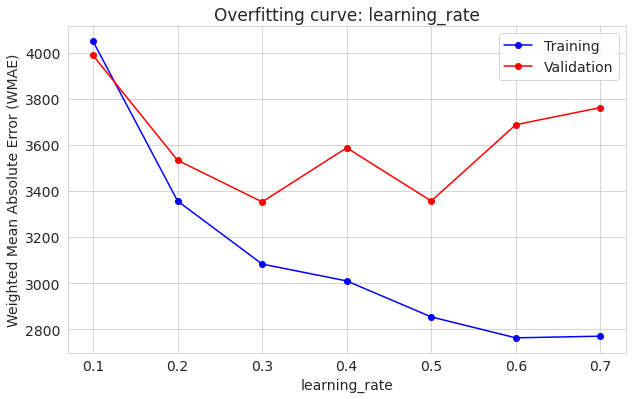

In [21]:
test_param_and_plot_xgb('learning_rate', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [22]:
gradient_boosting_regressor_model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=700,
                                                 max_depth=13, learning_rate=0.3).fit(X_train, train_targets)

In [23]:
test_param_xgb(n_estimators=700, max_depth=13, learning_rate=0.3)

(74.5099914498765, 2447.4359217880965)

I have managed to reduce the validation error from 3353.41 to 2447.44, in the gradient boosting regressor model, by tuning the hyperparameters.

In [24]:
gradient_boosting_regressor_model.score(X_train, train_targets)

0.9999740909042913

In [25]:
gradient_boosting_regressor_model.score(X_val, val_targets)

0.9494484982347653

In [26]:
importances_xgb_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gradient_boosting_regressor_model.feature_importances_
}).sort_values('importance', ascending=False)

In [27]:
importances_xgb_df

,feature,importance
7,Size,0.323162
10,Type_B,0.250800
1,Dept,0.143550
8,Week,0.099041
9,Type_A,0.083122
0,Store,0.027926
5,CPI,0.025694
6,Unemployment,0.022392
2,IsHoliday,0.017956
4,Fuel_Price,0.002945


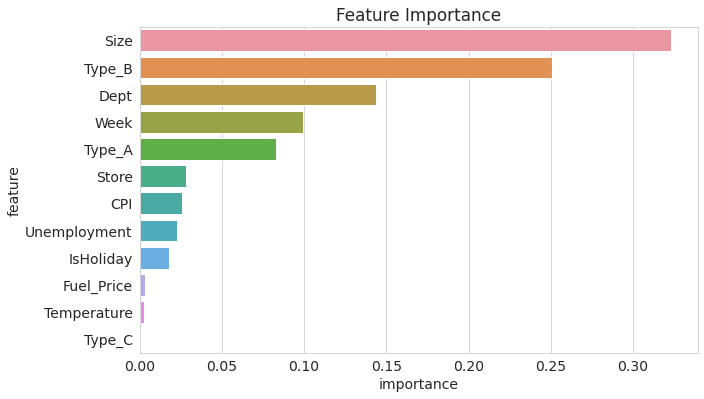

In [28]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importances_xgb_df, x='importance', y='feature');

In [29]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "wagb2b2/course-project-forecasting-walmart-sales" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales


'https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales'

# 5 - Reporting the performance of the best model and predicting sales of the test dataset

The best model I built in this project is the `random_forest_regressor_model`, with the hyperparameters tuned. This model has a training error of `611.82` and a validation error of `2183.89` on the prediction of the weekly sales, compared to the real values of weekly sales (the error metric I used was the weighted mean absolute error, with a weight of 5 for holiday weeks, and a weight of 1 for non-holiday weeks). The coefficient of determination ($R^2$) of this model is `0.9965` for the training dataset, and `0.9573` for the validation dataset.

To predict the sales on the test dataset, I will use the `random_forest_regressor_model` mentioned above, then I will add a column on the DataFrame with the predicted sales, and save it.

In [30]:
X_test['Predicted_sales'] = random_forest_regressor_model.predict(X_test)
X_test.head(15)

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Week,Type_A,Type_B,Type_C,Predicted_sales
0,0.0,0.000000,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,33313.020409
1,0.0,0.010204,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,41419.964955
2,0.0,0.020408,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,8209.400943
3,0.0,0.030612,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,35220.375545
4,0.0,0.040816,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,28176.227455
5,0.0,0.051020,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,3904.980970
6,0.0,0.061224,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,22384.799773
7,0.0,0.071429,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,34270.315409
8,0.0,0.081633,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,40396.165227
9,0.0,0.091837,0.0,0.573142,0.457916,0.946424,0.271804,0.630267,0.843137,1.0,0.0,0.0,31746.096091


Saving this DataFrame object into a csv file on disk:

In [31]:
X_test.to_csv('Predictions.csv')

To save the model weights:

In [ ]:
joblib.dump(random_forest_regressor_model, 'random_forest_regressor_model.joblib')

In [ ]:
jovian.commit()

# 6 - Summary, ideas for future work and references

During this project, my objective was to build a machine learning model to predict Walmart weekly sales. I started by installing and importing the necessary modules and downloading the data (Section 1), then I spent some time to understand the dataset and the problem description (Section 2). After that, I did the data preparation and exploratory data analysis (Section 3), which is necessary in order to understand more deeply the patterns of the sales over time, in relation to the type of store, to the size of the store, and other variables. With a better understanding of the patterns in the data, I could then finally train, evaluate and improve two different machine learning models (Section 4), and for this data I chose a random forest regressor model and a gradient boosting regressor model, since the variable I needed to predict was a continuous variable (weekly sales). The best model according to the validation error/score was the random forest regressor model, so this was the model I used to predict the weekly sales for the test dataset (Section 5).

Some ideas for future work on this topic are:

* Integrate the `markdown` variables in the exploratory data analysis and in the machine learning models;
* Tune other hyperparameters which I haven't tuned on my machine learning models;
* Test how other machine learning models perform with this dataset;


References:
* <https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting>
* <https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting>
* <https://scikit-learn.org/stable/>
* <https://scikit-learn.org/stable/modules/preprocessing.html>
* <https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees>
* <https://xgboost.readthedocs.io/en/latest/>
* <https://www.investopedia.com/terms/c/consumerpriceindex.asp>
* <https://jovian.ai/>
* <https://jovian.ai/aakashns/sklearn-decision-trees-random-forests>
* <https://jovian.ai/aakashns/python-gradient-boosting-machines>

In [32]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "wagb2b2/course-project-forecasting-walmart-sales" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales


'https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales'

In [33]:
jovian.submit(assignment="zerotogbms-project")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "wagb2b2/course-project-forecasting-walmart-sales" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/wagb2b2/course-project-forecasting-walmart-sales
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/assignment/course-project-real-world-machine-learning-model
